In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils


/tmp/ipykernel_3132191/1351946695.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def normalize_cooperation_matrix(cooperation_matrix_df):
    """
    Normalize cooperation counts by dividing each count by the total count for carrier1.
    
    Args:
        cooperation_matrix_df (pd.DataFrame): DataFrame with columns ['carrier1', 'carrier2', 'cooperation_count']
    
    Returns:
        pd.DataFrame: Normalized cooperation matrix DataFrame
    """
    # Get sum of cooperation_count grouped by carrier1
    carrier1_sums = cooperation_matrix_df.groupby('carrier1')['cooperation_count'].sum()

    # Normalize cooperation_count by dividing by carrier1 sum
    normalized_df = cooperation_matrix_df.copy()
    normalized_df['cooperation_count'] = normalized_df.apply(
        lambda x: x['cooperation_count'] / carrier1_sums[x['carrier1']], 
        axis=1
    )
    
    return normalized_df

def filter_cooperation_matrix(cooperation_matrix_df, threshold=0.1):
    """
    Filter cooperation matrix to keep only pairs where at least one direction has cooperation count above threshold.
    
    Args:
        cooperation_matrix_df (pd.DataFrame): DataFrame with columns ['carrier1', 'carrier2', 'cooperation_count']
        threshold (float): Minimum cooperation count threshold
        
    Returns:
        pd.DataFrame: Filtered cooperation matrix DataFrame
    """
    # Create a dictionary to store max cooperation count for each carrier pair
    pair_max_coop = {}
    
    # Find max cooperation count for each carrier pair
    for _, row in cooperation_matrix_df.iterrows():
        carrier1, carrier2 = row['carrier1'], row['carrier2']
        coop_count = row['cooperation_count']
        
        # Store pair in canonical order (alphabetically)
        pair = tuple(sorted([carrier1, carrier2]))
        
        if pair not in pair_max_coop:
            pair_max_coop[pair] = coop_count
        else:
            pair_max_coop[pair] = max(pair_max_coop[pair], coop_count)
    
    # Filter rows where max cooperation count exceeds threshold
    filtered_df = cooperation_matrix_df[
        cooperation_matrix_df.apply(
            lambda x: pair_max_coop[tuple(sorted([x['carrier1'], x['carrier2']]))] >= threshold,
            axis=1
        )
    ]
    
    return filtered_df

def average_cooperation_matrix(cooperation_matrix_df):
    """
    For each carrier pair, compute the mean cooperation count and keep only one entry.
    
    Args:
        cooperation_matrix_df (pd.DataFrame): DataFrame with columns ['carrier1', 'carrier2', 'cooperation_count']
        
    Returns:
        pd.DataFrame: Averaged cooperation matrix DataFrame with unique carrier pairs
    """
    # Create a dictionary to store mean cooperation count for each carrier pair
    pair_mean_coop = {}
    pair_entries = {}
    
    # Calculate mean cooperation count for each carrier pair
    for _, row in cooperation_matrix_df.iterrows():
        carrier1, carrier2 = row['carrier1'], row['carrier2']
        coop_count = row['cooperation_count']
        
        # Store pair in canonical order (alphabetically)
        pair = tuple(sorted([carrier1, carrier2]))
        
        if pair not in pair_mean_coop:
            pair_mean_coop[pair] = coop_count
            pair_entries[pair] = [(carrier1, carrier2, coop_count)]
        else:
            pair_entries[pair].append((carrier1, carrier2, coop_count))
            # Update mean
            pair_mean_coop[pair] = sum(x[2] for x in pair_entries[pair]) / len(pair_entries[pair])
    
    # Create new DataFrame with averaged values, keeping first carrier ordering for each pair
    averaged_rows = []
    for pair, entries in pair_entries.items():
        first_entry = entries[0]
        averaged_rows.append({
            'carrier1': first_entry[0],
            'carrier2': first_entry[1],
            'cooperation_count': pair_mean_coop[pair]
        })
    
    return pd.DataFrame(averaged_rows)



def define_node_shapes():

    #good_carriers = ['AA','MQ','PT', 'OH', 'UA', 'C5', 'G7', 'YV', 'DL', '9E', 'AS', 'QX', 'WN', 'NK', 'B6', 'F9', 'ZW', 'YX', 'OO']
    
    node_shape = {}
    
    node_shape['AA'] = 'o'
    node_shape['MQ'] = 'o'
    node_shape['PT'] = 'o'
    node_shape['OH'] = 'o'

    node_shape['ZW'] = '8'
    node_shape['YX'] = '8'
    node_shape['OO'] = '8'

    node_shape['UA'] = 's'
    node_shape['C5'] = 's'
    node_shape['G7'] = 's'
    node_shape['YV'] = 's'

    node_shape['DL'] = 'p'
    node_shape['9E'] = 'p'

    node_shape['AS'] = 'H'
    node_shape['QX'] = 'H'
    

    node_shape['WN'] = 'D'
    node_shape['NK'] = 'D'
    node_shape['B6'] = 'D'
    node_shape['F9'] = 'D'

    node_shape['CP'] = 'X'  # Triangle up marker shape for CP carrier
    node_shape['AX'] = 'X'  # Square marker shape for AX carrier
    node_shape['EV'] = 'X'  # Square marker shape for EV carrier


    return node_shape


def plot_market_share_network(db1b_matrix_df, ax, add_colorbar=False):

    normalized_db1b_matrix_df = normalize_cooperation_matrix(db1b_matrix_df)
    filtered_db1b_matrix_df = filter_cooperation_matrix(normalized_db1b_matrix_df, 
                                                        threshold=0.1)
    averaged_db1b_matrix_df = average_cooperation_matrix(filtered_db1b_matrix_df)

    db1b_edges = averaged_db1b_matrix_df.values
    filtered_edges = [(u,v,w) for u,v,w in db1b_edges if u != v]

    # Get the node shapes dictionary to use its order
    node_shapes = define_node_shapes()
    db1b_nodes = normalized_db1b_matrix_df[normalized_db1b_matrix_df['carrier1'] == normalized_db1b_matrix_df['carrier2']][['carrier1', 'cooperation_count']].values
    db1b_node_sizes = db1b_matrix_df.groupby('carrier1').sum().reset_index()[['carrier1', 'cooperation_count']].values

    # Sort db1b_nodes based on the order of keys in node_shapes
    db1b_nodes = np.array(sorted(db1b_nodes, key=lambda x: list(node_shapes.keys()).index(x[0])))
    db1b_node_sizes = np.array(sorted(db1b_node_sizes, key=lambda x: list(node_shapes.keys()).index(x[0])))

    # log scaling of the node sizes
    alpha=50
    db1b_node_sizes = alpha * np.log(alpha*db1b_node_sizes[:, 1].astype(float))

    G = nx.Graph()

    G.add_nodes_from(db1b_nodes[:,0])
    G.add_weighted_edges_from(filtered_edges)

    node_shapes_dict = define_node_shapes()
    node_shapes = [define_node_shapes()[node] for node in G.nodes()]
    node_color = db1b_nodes[:, 1]


    edge_widths = [8*G[u][v]['weight'] for u,v in G.edges()]
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]



    pos = nx.circular_layout(G)
    for node, shape in node_shapes_dict.items():
        try:
            nx.draw_networkx_nodes(G, pos,
                                nodelist=[node],
                                node_shape=shape,
                                node_size = db1b_node_sizes[list(G.nodes()).index(node)],
                                node_color=[node_color[list(G.nodes()).index(node)]],
                                cmap=plt.cm.coolwarm,
                                vmin=0,
                                vmax=1,
                                ax=ax
                                )
        except:
            pass
        
    edges = nx.draw_networkx_edges(G, pos, 
                                width=edge_widths, 
                                edge_color=edge_colors, 
                                edge_cmap=plt.cm.coolwarm, 
                                edge_vmin=0,
                                edge_vmax=1,
                                ax=ax)
    nx.draw_networkx_labels(G, pos, font_color='w', ax=ax)  # Add this line to show node labels in white

    if add_colorbar:
        plt.colorbar(edges)  # Add colorbar for the edge colors
    # plt.show()


def plot_full_market_share_network(figure_file_name, adj_matrix1, adj_matrix2, adj_matrix3):
    fig, ax = plt.subplots(ncols=3, figsize=(18, 5.5))

    plot_market_share_network(adj_matrix1, ax=ax[0])
    plot_market_share_network(adj_matrix2, ax=ax[1])
    plot_market_share_network(adj_matrix3, ax=ax[2])

    # Create a new axis for the colorbar that spans all subplots
    # Add colorbar before tight_layout to reserve space
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0', '1'], fontsize=20)
    cbar.set_label('market share', fontsize=20)

    ax[0].text(0.85, 0.9, '(a)', fontsize=30, transform=ax[0].transAxes)
    ax[1].text(0.85, 0.9, '(b)', fontsize=30, transform=ax[1].transAxes)
    ax[2].text(0.85, 0.9, '(c)', fontsize=30, transform=ax[2].transAxes)

    # Adjust layout after adding colorbar
    plt.subplots_adjust(right=0.9)  # Make room for colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout while preserving colorbar space


    plt.savefig(figure_file_name, bbox_inches='tight', format='pdf')
    plt.show()

In [10]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2023
MONTH = 4
DATE = [18]
CARRIER = "all"

flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))

In [11]:
db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)

In [12]:
fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_gravity_B_alliance_distance_r1.dat')
mcp_alliance_data = io_utils.read_data_file(fname)

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_gravity_B_coop_distance_r1.dat')
mcp_coop_data = io_utils.read_data_file(fname)

In [13]:
_, mcp_coop_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_coop_data, 
                                                                    flights_dict, 
                                                                    symmetry=True,
                                                                    halve_self_connections=True)

_, mcp_alliance_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_alliance_data, 
                                                                        flights_dict, 
                                                                        symmetry=True,
                                                                        halve_self_connections=True)

# available_carriers = set(mcp_coop_matrix_df[['carrier1', 'carrier2']].values.flatten())

available_carriers = define_node_shapes().keys()

db1b_matrix_df = preprocess_utils.get_db1b_cooperation_matrix(db1b_df, 
                                                              available_carriers=available_carriers, 
                                                              symmetry=True, 
                                                              halve_self_connections=True)




100%|██████████| 7616858/7616858 [00:06<00:00, 1182605.18it/s]


/tmp/ipykernel_3130462/2945670629.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout while preserving colorbar space


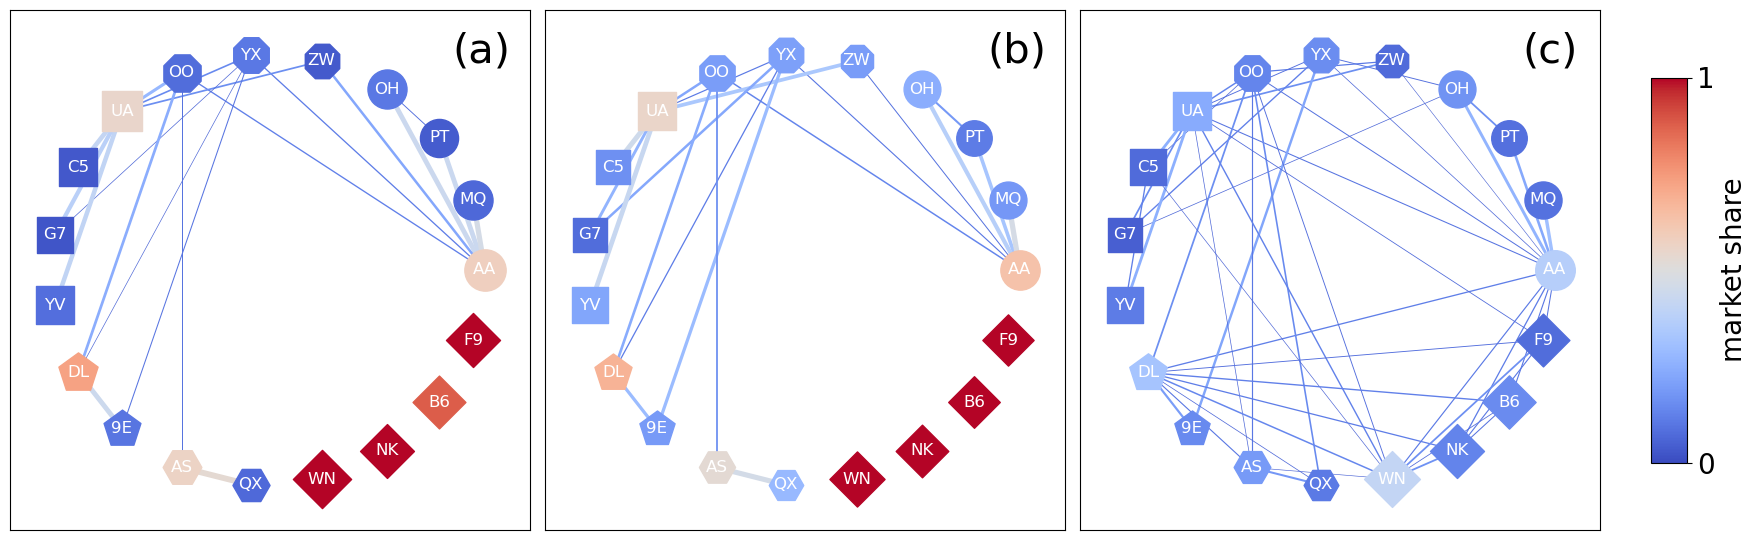

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5.5))

plot_market_share_network(db1b_matrix_df, ax=ax[0])
plot_market_share_network(mcp_alliance_matrix_df, ax=ax[1])
plot_market_share_network(mcp_coop_matrix_df, ax=ax[2])

# Create a new axis for the colorbar that spans all subplots
# Add colorbar before tight_layout to reserve space
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '1'], fontsize=20)
cbar.set_label('market share', fontsize=20)

ax[0].text(0.85, 0.9, '(a)', fontsize=30, transform=ax[0].transAxes)
ax[1].text(0.85, 0.9, '(b)', fontsize=30, transform=ax[1].transAxes)
ax[2].text(0.85, 0.9, '(c)', fontsize=30, transform=ax[2].transAxes)

# Adjust layout after adding colorbar
plt.subplots_adjust(right=0.9)  # Make room for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout while preserving colorbar space


plt.savefig('../results/manuscript/figure4.pdf', bbox_inches='tight', format='pdf')
plt.show()


# Additional code for SM

In [14]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2019
MONTH = 4
DATE = [18]
CARRIER = "all"

cost_type = "seats"
demand_type = "gravity_B"

flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))

db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_{demand_type}_alliance_{cost_type}_r1.dat')
mcp_alliance_data = io_utils.read_data_file(fname)

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_{demand_type}_coop_{cost_type}_r1.dat')
mcp_coop_data = io_utils.read_data_file(fname)

figure_file_name = f"../results/manuscript/SM-market-share-network-{demand_type}-{cost_type}-Y{YEAR}M{MONTH}D{DATE[0]}.pdf"

In [15]:
# available_carriers = define_node_shapes().keys()

_, mcp_coop_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_coop_data, 
                                                                    flights_dict, 
                                                                    symmetry=True,
                                                                    halve_self_connections=True)

_, mcp_alliance_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_alliance_data, 
                                                                        flights_dict, 
                                                                        symmetry=True,
                                                                        halve_self_connections=True)

# I will loose some carriers due to the filtering for April 18, 2019
# mcp_coop_matrix_df = mcp_coop_matrix_df[mcp_coop_matrix_df['carrier1'].isin(available_carriers) & mcp_coop_matrix_df['carrier2'].isin(available_carriers)]
# mcp_alliance_matrix_df = mcp_alliance_matrix_df[mcp_alliance_matrix_df['carrier1'].isin(available_carriers) & mcp_alliance_matrix_df['carrier2'].isin(available_carriers)]

available_carriers = set(mcp_coop_matrix_df[['carrier1', 'carrier2']].values.flatten())


db1b_matrix_df = preprocess_utils.get_db1b_cooperation_matrix(db1b_df, 
                                                              available_carriers=available_carriers, 
                                                              symmetry=True, 
                                                              halve_self_connections=True)



100%|██████████| 7465479/7465479 [00:07<00:00, 1063518.91it/s]


/tmp/ipykernel_3132191/330896533.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout while preserving colorbar space


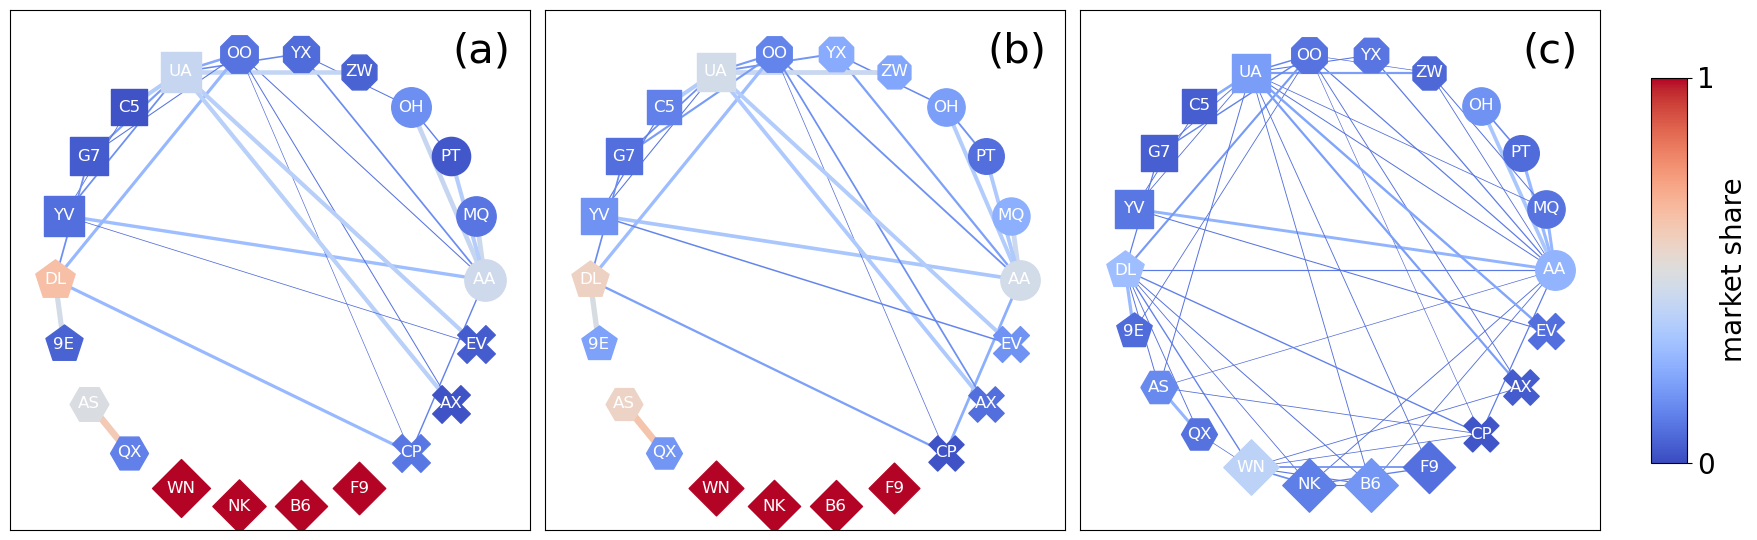

In [16]:
plot_full_market_share_network(figure_file_name, db1b_matrix_df, mcp_alliance_matrix_df, mcp_coop_matrix_df)

In [17]:
figure_file_name

'../results/manuscript/SM-market-share-network-gravity_B-seats-Y2019M4D18.pdf'

# 2019-04-18

We have additional carriers on April 18, 2019, thus it requires some modifications to the first code.


In [3]:
def normalize_cooperation_matrix(cooperation_matrix_df):
    """
    Normalize cooperation counts by dividing each count by the total count for carrier1.
    
    Args:
        cooperation_matrix_df (pd.DataFrame): DataFrame with columns ['carrier1', 'carrier2', 'cooperation_count']
    
    Returns:
        pd.DataFrame: Normalized cooperation matrix DataFrame
    """
    # Get sum of cooperation_count grouped by carrier1
    carrier1_sums = cooperation_matrix_df.groupby('carrier1')['cooperation_count'].sum()

    # Normalize cooperation_count by dividing by carrier1 sum
    normalized_df = cooperation_matrix_df.copy()
    normalized_df['cooperation_count'] = normalized_df.apply(
        lambda x: x['cooperation_count'] / carrier1_sums[x['carrier1']], 
        axis=1
    )
    
    return normalized_df

carrier_order = ["AA", "MQ", "PT", "OH",  # American Airlines and its subsidiaries (American Eagle)
                 "UA", "C5", "G7", "YV",  # United Airlines and its regional partners (United Express) 
                 "DL", "9E",  # Delta Air Lines and its regional partners (Delta Connection)
                 "AS", "QX",  # Alaska Airlines and its regional partners (Horizon Air, SkyWest Airlines)
                 "ZW", "YX", "OO",
                 "WN",  # Southwest Airlines (independent)
                 "NK",  # Spirit Airlines (independent)
                 "B6",  # JetBlue Airways (independent)
                 "F9"]  # Frontier Airlines (independent)

def get_pivotted_matrix(cooperation_matrix_df, carrier_order=None, normalize=True):

    if normalize:
        cooperation_matrix = normalize_cooperation_matrix(cooperation_matrix_df)

    hm_matrix = cooperation_matrix.pivot(index='carrier1', 
                                         columns='carrier2', 
                                         values='cooperation_count')
    if carrier_order is not None:
        hm_matrix = hm_matrix.reindex(index=carrier_order, columns=carrier_order)

    return hm_matrix

In [4]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2019
MONTH = 4
DATE = [18]
CARRIER = "all"

flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))

In [5]:
db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)

In [6]:
fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_gravity_B_alliance_distance_r1.dat')
mcp_alliance_data = io_utils.read_data_file(fname)

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_gravity_B_coop_distance_r1.dat')
mcp_coop_data = io_utils.read_data_file(fname)

In [7]:
_, mcp_coop_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_coop_data, 
                                                                    flights_dict, 
                                                                    symmetry=True,
                                                                    halve_self_connections=True)

_, mcp_alliance_matrix_df = preprocess_utils.get_mcp_cooperation_matrix(mcp_alliance_data, 
                                                                        flights_dict, 
                                                                        symmetry=True,
                                                                        halve_self_connections=True)

available_carriers = set(mcp_coop_matrix_df[['carrier1', 'carrier2']].values.flatten())

db1b_matrix_df = preprocess_utils.get_db1b_cooperation_matrix(db1b_df, 
                                                              available_carriers=None, 
                                                              symmetry=True, 
                                                              halve_self_connections=True)




100%|██████████| 7465479/7465479 [00:06<00:00, 1130782.60it/s]


In [56]:
extra_carriers = list(set(available_carriers) - set(carrier_order))
extra_carriers

['CP', 'AX', 'EV']

In [57]:
print("MCP alliance matrix:")
num_passengers = mcp_alliance_matrix_df['cooperation_count'].sum()
num_passengers_extra = mcp_alliance_matrix_df[~mcp_alliance_matrix_df['carrier1'].isin(carrier_order) | ~mcp_alliance_matrix_df['carrier2'].isin(carrier_order)]['cooperation_count'].sum()
print(f"fraction of passengers from extra carriers: {num_passengers_extra / num_passengers}")

print("MCP cooperation matrix:")
num_passengers = mcp_coop_matrix_df['cooperation_count'].sum()
num_passengers_extra = mcp_coop_matrix_df[~mcp_coop_matrix_df['carrier1'].isin(carrier_order) | ~mcp_coop_matrix_df['carrier2'].isin(carrier_order)]['cooperation_count'].sum()
print(f"fraction of passengers from extra carriers: {num_passengers_extra / num_passengers}")

print("DB1B cooperation matrix:")
num_passengers = db1b_matrix_df['cooperation_count'].sum()
num_passengers_extra = db1b_matrix_df[~db1b_matrix_df['carrier1'].isin(carrier_order) | ~db1b_matrix_df['carrier2'].isin(carrier_order)]['cooperation_count'].sum()
print(f"fraction of passengers from extra carriers: {num_passengers_extra / num_passengers}")




MCP alliance matrix:
fraction of passengers from extra carriers: 0.048929657136871196
MCP cooperation matrix:
fraction of passengers from extra carriers: 0.041163795962675
DB1B cooperation matrix:
fraction of passengers from extra carriers: 0.09469108036476664


In [ ]:
'''
2023-04-18

MCP alliance matrix:
fraction of passengers from extra carriers: 0.0
MCP cooperation matrix:
fraction of passengers from extra carriers: 0.0
DB1B cooperation matrix (without any filtering):
fraction of passengers from extra carriers: 0.049059042782425635

2019-04-18

MCP alliance matrix:
fraction of passengers from extra carriers: 0.048929657136871196
MCP cooperation matrix:
fraction of passengers from extra carriers: 0.041163795962675
DB1B cooperation matrix (without any filtering):
fraction of passengers from extra carriers: 0.09469108036476664

MCP alliance matrix:
fraction of passengers from extra carriers: 0.048929657136871196
MCP cooperation matrix:
fraction of passengers from extra carriers: 0.041163795962675
DB1B cooperation matrix (after filtering):
fraction of passengers from extra carriers: 0.052588501013182014


2023-11-22

MCP alliance matrix:
fraction of passengers from extra carriers: 0.0
MCP cooperation matrix:
fraction of passengers from extra carriers: 0.0
DB1B cooperation matrix:
fraction of passengers from extra carriers: 0.04699433455197992
'''

,carrier1,carrier2,cooperation_count
0,NK,NK,47854
1,NK,F9,0
2,NK,9E,0
3,NK,PT,0
4,NK,G7,0
...,...,...,...
479,YX,AA,35058
480,YX,ZW,1312
481,YX,B6,0
482,YX,CP,71
